In [1]:
#Импортируем все нужные библиотеки и модули
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
#Считываем данные
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', index_col=0)

In [3]:
#Приводим колонку value. к типу данных float:
df['value'] = df['value'].str.replace(',', '.').astype(np.float64)
df.dtypes

value                float64
experimentVariant     object
dtype: object

1. Сравниваем результат между тестом и контролем, применяя бутстрап (с np.mean)

H0 - значения статистики метрики (value) для групп Control и Treatment статистически не различаются

H1 - имеются статистические различия значений статистики метрики для групп Control и Treatment

In [4]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Создаем отдельные распределения Control и Treatment:

In [5]:
column_1 = df.query('experimentVariant == "Control"').value

In [6]:
column_2 = df.query('experimentVariant == "Treatment"').value

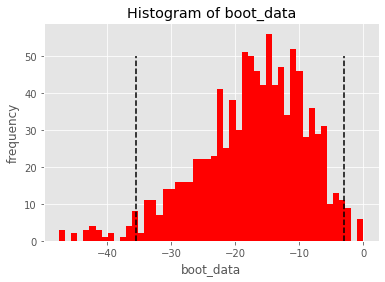

In [7]:
#Применяем функцию
booted_data = get_bootstrap(column_1, column_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [8]:
#выводим рассчитанное pvalue
booted_data["p_value"]

0.04044744911006735

In [9]:
#выводим доверительный интервал
booted_data["quants"]

,0
0.025,-35.586433
0.975,-3.036164


Вывод:
Исходя из результатов, полученный с применением бустрапа (с оценкой среднего), мы можем увидеть наличие статистически значимых различий в распределениях средних значений метрики value для групп Control и Treatment (pvalue < 0.05, а также 0 не входит в ДИ). Следовательно, мы могли бы отклонить нулевую гипотезу о равенстве средних value для наших групп.

In [10]:
2. Сравниваем результат между тестом и контролем, применяя бутстрап (с np.median) и критерий mann-whitney.

SyntaxError: invalid syntax (<ipython-input-10-177fddc97150>, line 1)

In [11]:
#Меняем параметр statistics в формуле на np.median
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

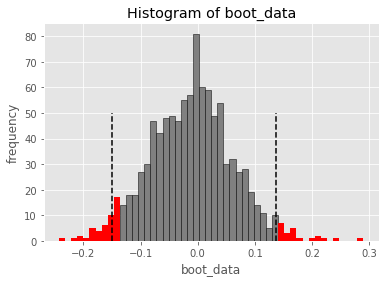

In [12]:
booted_data_2 = get_bootstrap_median(column_1, column_2)

In [13]:
booted_data_2["p_value"]

0.8780585593721991

In [14]:
booted_data_2["quants"]

,0
0.025,-0.150022
0.975,0.136548


In [16]:
#Рассчитываем коэффициент Манна-Уитни
p = mannwhitneyu(column_1, column_2)
p

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

Выводы по второй части:
Сравнение медиан с помощью бустрапа показало, что значение pvalue > 0.05 в данном случае, а также 0 входит в ДИ. 
U-критерий МаннаУитни так же не дал нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы (pvalue > 0.05)
Это не позволяет нам сделать заявление о статистически значимых различиях медиан в группах Control и Treatment, следовательно, мы не можем отклонить нулевую гипотезу.

Общие выводы:
    Исходя из полученных данных, мы можем сделать выводы, что средние значения в двух группах статистически различаются (тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение). А вот медианы статистически значимых различий не имеют.